In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Twitter on fire !! 
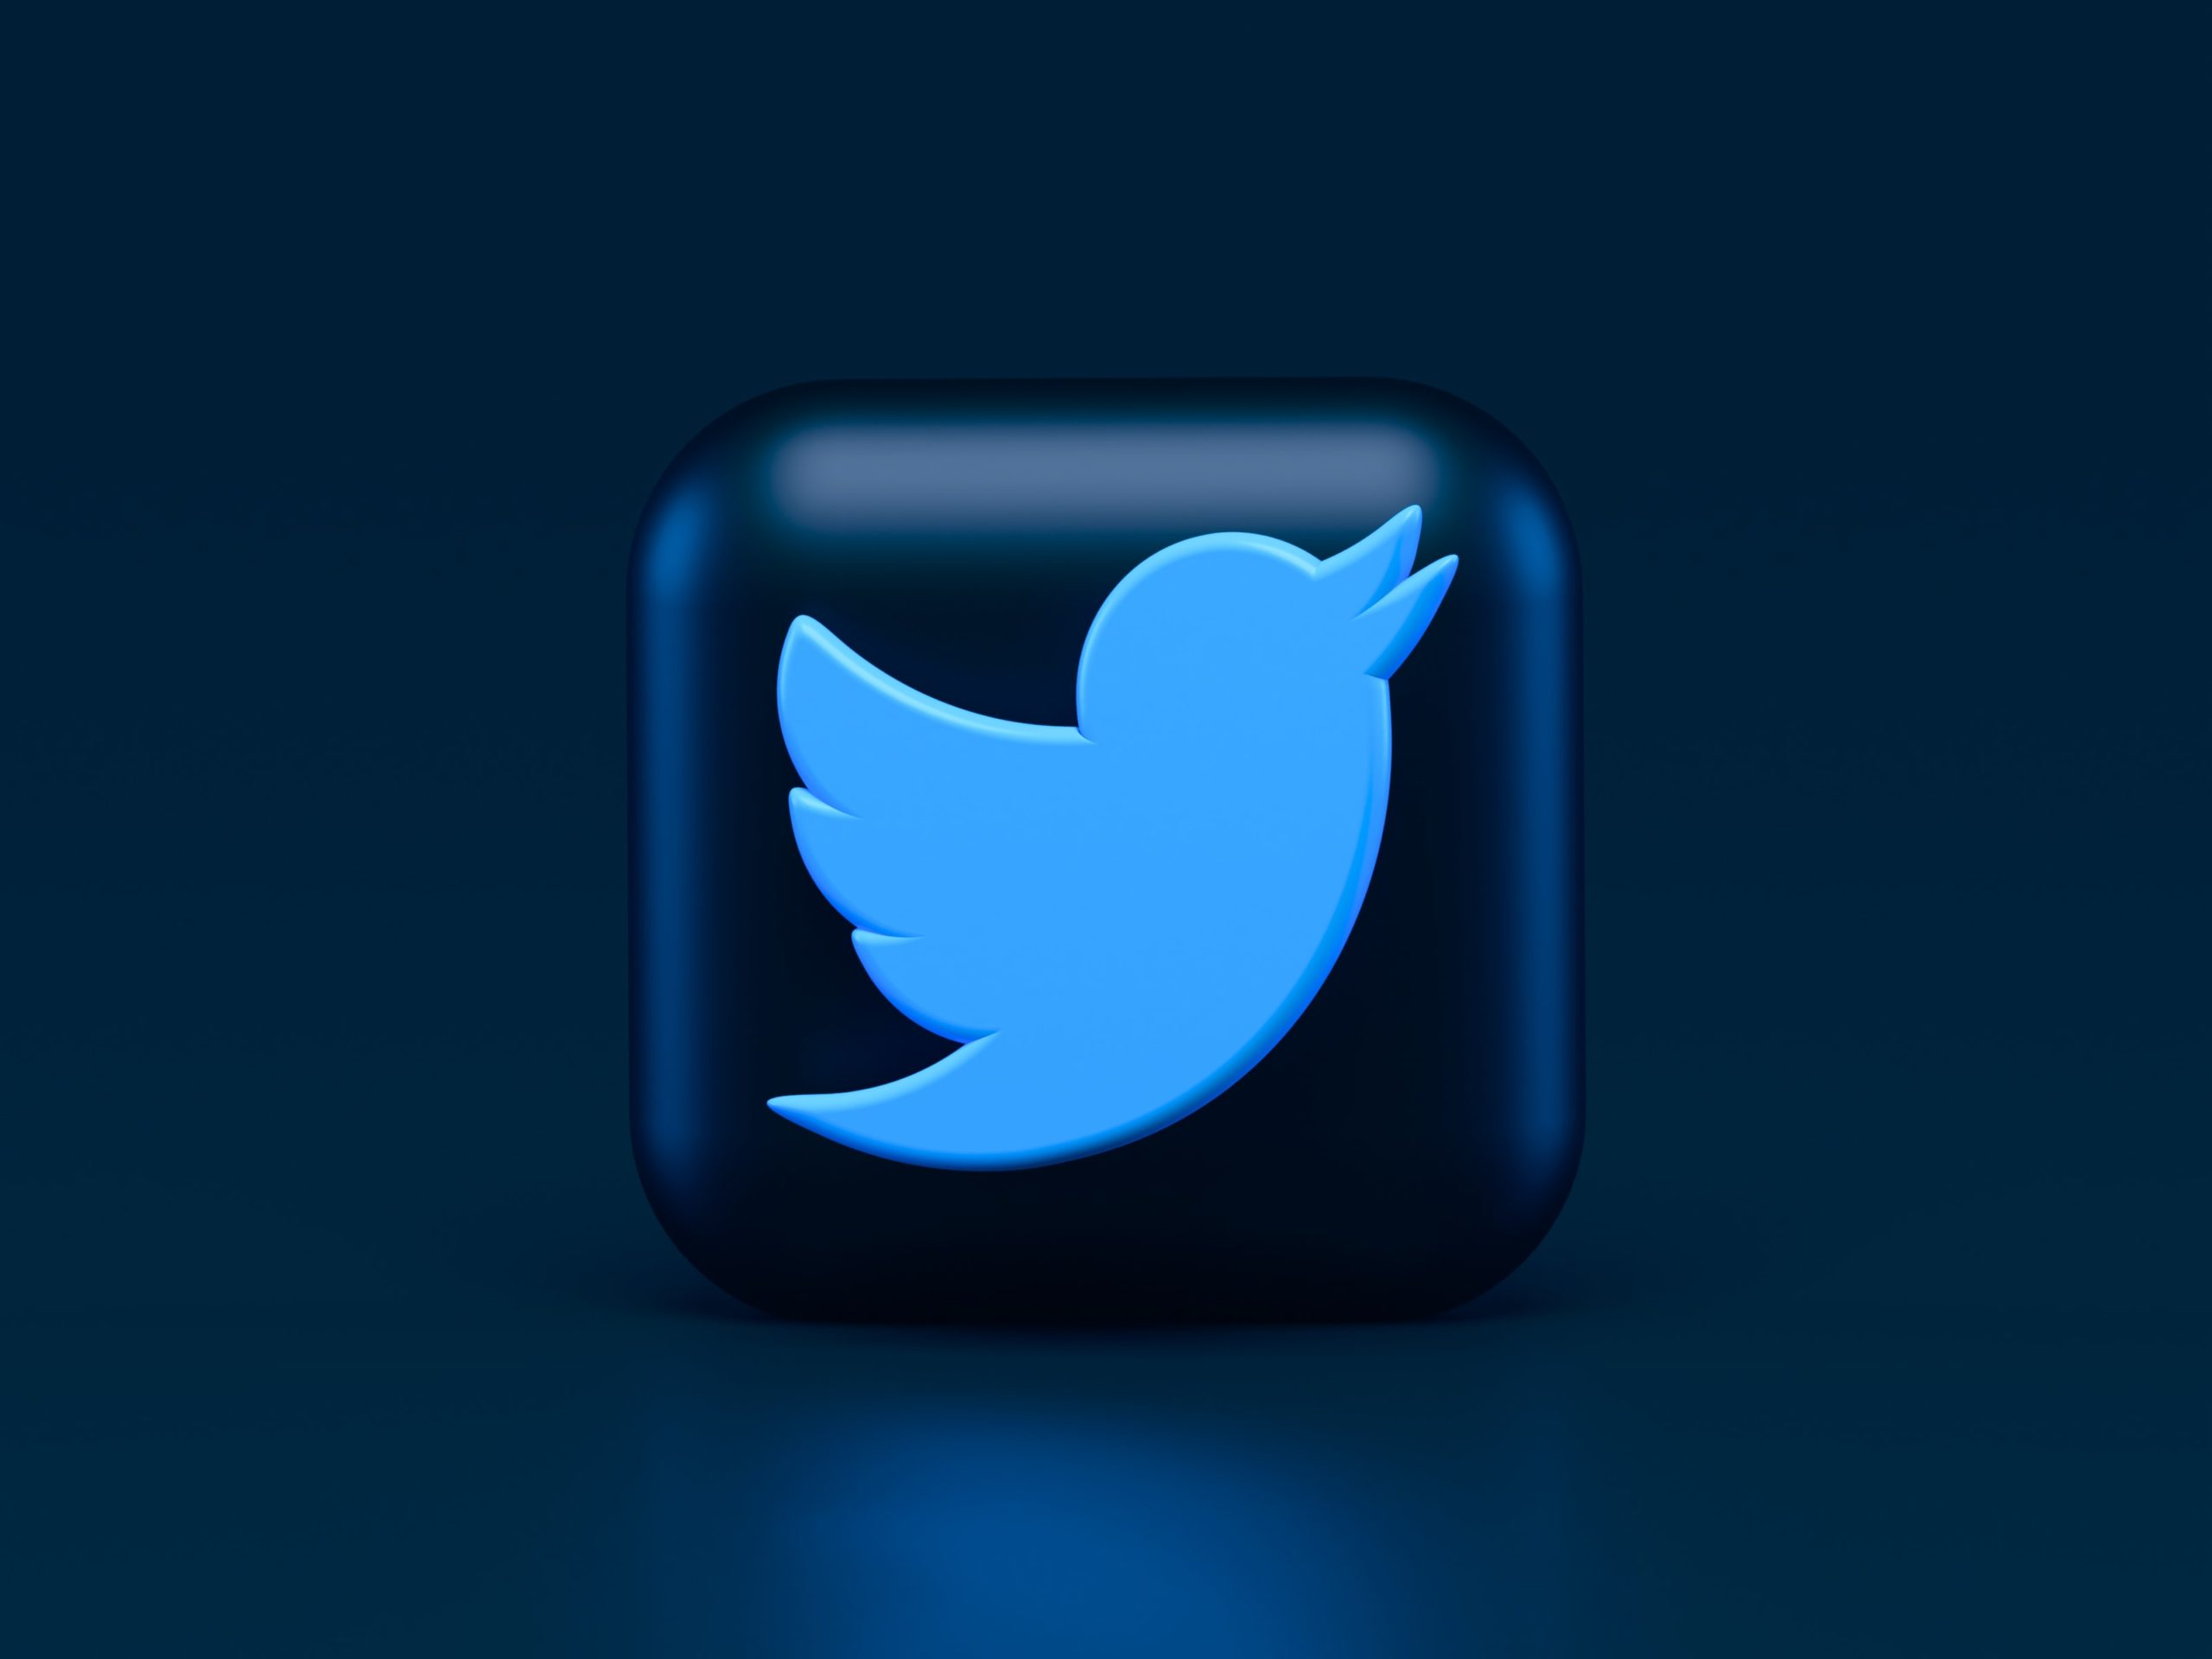NLP project

**Introduction** 

Twitter est devenu un canal de communication important en cas d'urgence. L'omniprésence des smartphones permet aux gens d'annoncer une urgence qu'ils observent en temps réel. Pour cette raison, de plus en plus d'agences sont intéressées par une surveillance programmatique de Twitter.

Mais, il n'est pas toujours clair si les paroles d'une personne annoncent réellement une catastrophe.

L'auteur utilise explicitement le mot « ABLAZE » (en feu) mais le signifie métaphoriquement. C'est tout de suite clair pour un humain, surtout avec l'aide visuelle. Mais c'est moins clair pour une machine.

Dans ce concours paru sur Kaggle, le projet est de créer un modèle d'apprentissage automatique qui prédit quels Tweets concernent de véritables catastrophes et lesquels ne le sont pas. 
Nous avons accès à un ensemble de données de 10 000 tweets classés manuellement.

##Import des librairies et premières manipulations de données

In [ ]:
import spacy

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [ ]:
!pip install wordcloud -q
!pip install -U spacy -q
#!python -m spacy download en_core_web_sm -q
!pip install tensorflow -q
import pandas as pd 
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import pathlib 
import os
import io
import tensorflow as tf 
from sklearn.model_selection import train_test_split
import warnings
import spacy
#from spacy.lang.en.examples import sentences 
import re 
import en_core_web_sm
from keras import regularizers
from keras.layers.recurrent import LSTM
#nlp = spacy.load("en_core_web_sm")
from spacy.lang.en.stop_words import STOP_WORDS
warnings.filterwarnings('ignore')

In [ ]:
path='/content/drive/MyDrive/train._kaggle.csv' 
df = pd.read_csv(path)

In [ ]:
df.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [ ]:
df.shape

(7613, 5)

In [ ]:
#ici nous allons vérifier l'existence de doublons et les supprimer.
df.duplicated(subset=['text']).sum()

110

In [ ]:
df=df.drop_duplicates(subset=['text'], keep='first')

In [ ]:
df['target'].nunique()

2

In [ ]:
# Nous ne gardons pas les colonnes keyword et location, qui ne nous serviront pas pour le projet.
df=df.iloc[:,3:]
df.head(10)

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
5,#RockyFire Update => California Hwy. 20 closed...,1
6,#flood #disaster Heavy rain causes flash flood...,1
7,I'm on top of the hill and I can see a fire in...,1
8,There's an emergency evacuation happening now ...,1
9,I'm afraid that the tornado is coming to our a...,1


#Preprocessing

In [ ]:
!python -m spacy download en_core_web_md -q

     |████████████████████████████████| 45.7 MB 1.1 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [ ]:
import en_core_web_md
from spacy.lang.en.stop_words import STOP_WORDS

In [ ]:
import en_core_web_sm
nlp = en_core_web_sm.load()

ImportError: ignored

Nous allons ici nettoyer le texte, c'est-à-dire supprimer les ponctuations et signes spéciaux. Nous allons également 'lemmatiser', c'est-à-dire que les mots seront reconnaissables à leur racine.

In [ ]:
df["text"] = df["text"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch in [" ","#"]))
df["text"] = df["text"].apply(lambda x: x.replace(" +"," ").lower().strip())
df["text"] = df["text"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)]))


NameError: ignored

In [ ]:
# Ici nous n'avons gardé que la version nettoyer, et après lemmatisation.
df.head(20)

,text,target
0,deed reason # earthquake allah forgive,1
1,forest fire near la ronge sask canada,1
2,resident ask shelter place notify officer evac...,1
3,13000 people receive # wildfire evacuation ord...,1
4,send photo ruby # alaska smoke # wildfire pour...,1
5,# rockyfire update california hwy 20 close d...,1
6,# flood # disaster heavy rain cause flash floo...,1
7,hill fire wood,1
8,s emergency evacuation happen building street,1
9,afraid tornado come area,1


In [ ]:
#Création d'une instance de Tokenize
tokenizer = tf.keras.preprocessing.text.Tokenizer() # instanciate the tokenizer
tokenizer.fit_on_texts(df.text)
df["text_encoded"] = tokenizer.texts_to_sequences(df.text)
df["len_text"] = df["text_encoded"].apply(lambda x: len(x))
df = df[df["len_text"]!=0]

In [ ]:
# On vérifie et constate alors le bon encodage du texte.
df

,text,target,text_encoded,len_text
0,deed reason # earthquake allah forgive,1,"[3629, 404, 169, 1486, 1909]",5
1,forest fire near la ronge sask canada,1,"[113, 2, 159, 498, 5465, 5466, 1061]",7
2,resident ask shelter place notify officer evac...,1,"[1353, 436, 1677, 326, 5467, 278, 196, 1677, 3...",11
3,13000 people receive # wildfire evacuation ord...,1,"[2278, 7, 2279, 67, 196, 294, 35]",7
4,send photo ruby # alaska smoke # wildfire pour...,1,"[170, 123, 5468, 1678, 164, 67, 2280, 107]",8
...,...,...,...,...
7604,# worldnews fall powerline glink tram update f...,1,"[1242, 80, 1655, 4777, 1347, 165, 2, 490, 79, ...",13
7605,flip walmart bomb evacuate stay tune blow,1,"[2098, 2160, 17, 79, 354, 1395, 75]",7
7606,suicide bomber kill 15 saudi security site mos...,1,"[41, 154, 8, 313, 254, 397, 406, 318, 522, 38,...",14
7608,giant crane hold bridge collapse nearby home h...,1,"[582, 919, 302, 244, 39, 470, 27, 20500]",8


In [ ]:
#Ici, nous attribuons une pad-séquence, c'est-à-dire une couche de padding afin que l'ensemble des phrases aient la même taille, élément essentiels pour une couche de neurones.
df_pad = tf.keras.preprocessing.sequence.pad_sequences(df.text_encoded, padding="post")

In [ ]:
#Création du dataset tensorflow
full_ds = tf.data.Dataset.from_tensor_slices((df_pad, df.target))

In [ ]:
# Train Test Split
TAKE_SIZE = int(0.7*df.shape[0])

train_data = full_ds.take(TAKE_SIZE).shuffle(TAKE_SIZE)
train_data = train_data.batch(64)

test_data = full_ds.skip(TAKE_SIZE)
test_data = test_data.batch(64)

In [ ]:
for text, target in train_data.take(1):
  print(text, target)

tf.Tensor(
[[  799  7087   505 ...     0     0     0]
 [  206 11320 11321 ...     0     0     0]
 [11683   133     0 ...     0     0     0]
 ...
 [15081   744 15082 ...     0     0     0]
 [  754  2339   888 ...     0     0     0]
 [  698  1135  2305 ...     0     0     0]], shape=(64, 25), dtype=int32) tf.Tensor(
[0 0 0 0 0 0 0 0 1 1 0 1 0 1 0 1 1 0 1 0 1 0 0 1 1 0 1 1 0 1 1 1 0 0 0 1 0
 0 1 1 0 0 1 0 0 0 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 0 1 0], shape=(64,), dtype=int64)


# Modeling


Nous allons maintenant créer un réseau de neurones artificiel afin que notre modèle puisse apprendre de lui même (et non de manière déterministe comme avec un modèle de programmation linéaire)

In [ ]:
len(tokenizer.word_index)

20501

In [ ]:
from tensorflow.keras.layers import GRU
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D

In [ ]:
vocab_size = len(tokenizer.word_index)+1

embedding_dim=64 # the dimensionality of the representation space

model = Sequential([
  Embedding(vocab_size, embedding_dim), # the embedding layer
  # the input dim needs to be equal to the size of the vocabulary + 1 (because of
  # the zero padding)
  GRU(units=64, return_sequences=True), # maintains the sequential nature
  GRU(units=32, return_sequences=False), # returns the last output
  Dense(16, activation='relu'), # a dense layer
  Dense(1, activation="sigmoid") # the prediction layer
])


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          1312128   
_________________________________________________________________
gru (GRU)                    (None, None, 64)          24960     
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                9408      
_________________________________________________________________
dense (Dense)                (None, 16)                528       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 1,347,041
Trainable params: 1,347,041
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
# Entrainement du modèle 
history = model.fit(train_data, 
                    epochs=15, 
                    validation_data=test_data)

Epoch 1/15
83/83 [==============================] - 10s 66ms/step - loss: 0.6822 - accuracy: 0.5762 - val_loss: 0.6853 - val_accuracy: 0.5629
Epoch 2/15
83/83 [==============================] - 5s 54ms/step - loss: 0.5545 - accuracy: 0.7064 - val_loss: 0.4940 - val_accuracy: 0.7628
Epoch 3/15
83/83 [==============================] - 5s 56ms/step - loss: 0.2798 - accuracy: 0.8920 - val_loss: 0.5195 - val_accuracy: 0.7481
Epoch 4/15
83/83 [==============================] - 5s 55ms/step - loss: 0.1396 - accuracy: 0.9572 - val_loss: 0.6297 - val_accuracy: 0.7446
Epoch 5/15
83/83 [==============================] - 5s 55ms/step - loss: 0.0676 - accuracy: 0.9787 - val_loss: 0.8883 - val_accuracy: 0.7081
Epoch 6/15
83/83 [==============================] - 5s 55ms/step - loss: 0.0340 - accuracy: 0.9916 - val_loss: 1.2917 - val_accuracy: 0.6375
Epoch 7/15
83/83 [==============================] - 5s 55ms/step - loss: 0.0773 - accuracy: 0.9777 - val_loss: 0.8633 - val_accuracy: 0.6992
Epoch 8/15
8

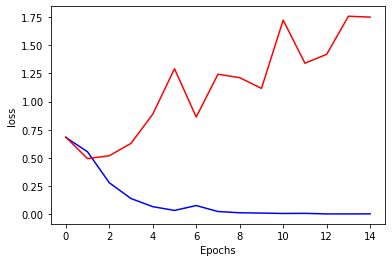

In [ ]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function 
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

In [ ]:
history.history.items()

dict_items([('loss', [0.6822332739830017, 0.5545106530189514, 0.27980220317840576, 0.13956260681152344, 0.06757429242134094, 0.034001629799604416, 0.07727396488189697, 0.02435437962412834, 0.013197116553783417, 0.010549068450927734, 0.007036141585558653, 0.008032692596316338, 0.0031583320815116167, 0.0030468616168946028, 0.0035480642691254616]), ('accuracy', [0.5761614441871643, 0.706397533416748, 0.8920411467552185, 0.957159161567688, 0.9786747694015503, 0.9916222095489502, 0.9777227640151978, 0.99390709400177, 0.9967631101608276, 0.9975247383117676, 0.9984767436981201, 0.9979055523872375, 0.99961918592453, 0.9994288086891174, 0.9994288086891174]), ('val_loss', [0.6853040456771851, 0.4940029978752136, 0.5194924473762512, 0.6297276020050049, 0.8882856369018555, 1.2917048931121826, 0.8633080124855042, 1.2431550025939941, 1.2127081155776978, 1.1172791719436646, 1.7234704494476318, 1.3410873413085938, 1.4201091527938843, 1.758063793182373, 1.7504562139511108]), ('val_accuracy', [0.5628609

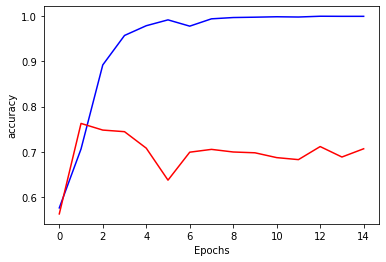

In [ ]:
# Visualization of accuracy training 
plt.plot(history.history["accuracy"], color="b")
plt.plot(history.history["val_accuracy"], color="r")
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.show()

In [ ]:
# Viewing a sample prediction
for sentences, labels in test_data.take(1):

  batch_preds = tf.math.argmax(model(sentences), axis=-1)
  print("Predictions : {}".format(batch_preds.numpy()))
  print("Truth : {}".format(labels.numpy()))

Predictions : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Truth : [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0]


#Conclusion

Nous avons commencé par initialiser notre réseau de neuronnes avec Sequential qui regroupe une pile linéaire de calculs dans un fichier tf.keras.Model.

Avec une première couche d'embeding qui est parfaite pour les données textuelles. La couche d'embeding nous permet de faire une sortie arbitraire et de convertir les mots en vecteur continu qui va aider à l'apprentissage de notre modèle.

(ex : chat = 0, mange = 1 , manger n'est pas supérieur à chat ce n'est pas linéaire )

Ensuite nous utilisons deux couches de GRU, versions simplifiées de LSTM,avec une activation sigmoidale.

Sur cette dernière, nous utiliserons une sigmoïde car elle lisse les valeurs de sortie qui sont comprises entre 0 et 1 normalisant les sorties de chaque neuronne. Elle est donc identique à notre target et parfaite pour avoir des prédictions claires.

On peut voir que notre modèle ici apprend trop vite et est rapidement en overfiting. (dès la 5 ème epoch).

Nous avons initialisé un nombre d'epoch à 15 notre modèle va donc regarder et apprendre de chaque batch que nous avons initialisé avant. Une fois qu'il aura regardé les 64 batch cela correspondra à une epoch. On remarque également que notre modèle apprend assez rapidement en regardant l'accuracy. 6 epoch lui suffisent pour apprendre correctement au-delà notre modèle n'apprend plus, l'accuracy stagne on obtient donc une accuracy à 99%.

On remarque également la val_loss qui est la valeur de la fonction de coût pour nos données de validation croisée et la loss est la valeur de la fonction de coût pour vos données d'entraînement. Notre modèle essai donc de minimiser ces 2 metrics. Afin de minimiser cette distance, le réseau de neurones apprend également en ajustant les poids et les biais de manière à réduire la perte. Et nous constatons de la même manière que nous arrivons à une stagnation rapide.

Pour aller plus loin : afin d'améliorer notre modèle, il serait intéressant d'aller un peu plus loin dans l'analyse des données d'entrées et vérifier ce que ces dernières peuvent contenir en potentiels biais ( notamment une target manuelle enregistrée de manière fausse). Pour le modèle quant à lui, il serait intéressant de réessayer sur un modèle plus simple afin d'éviter qu'il ne se sur entraine trop rapidement comme pour celui-ci.